# Load Configuration Data
```markdown
This section loads configuration data from a JSON file. It checks if the file exists at the specified path and reads its contents into a dictionary. If the file is not found, an error message is displayed.
```

In [96]:
import json
import os

# Check if the file exists and load the JSON file into a dictionary
file_path = r'C:\Users\mike\Develop\Projects\Code Notebook\Credentials\locations_conf.json'
if os.path.exists(file_path):
    with open(file_path, 'r') as f:
        locations_data = json.load(f)
    print(locations_data)
else:
    print(f"File not found: {file_path}")

{'Common_Funcs_Dir': '/Users/mike/Develop/Projects/Code Notebook/Common/Functions', 'Credentials_Dir': '/Users/mike/Develop/Projects/Code Notebook/Credentials', 'Rel_Pickes_Dir': '../.pickles', 'Pub_Data_Dir': "'/Users/mike/Data/Public", 'BQ_Service_Key': '/Users/mike/Develop/Conf/GCP Service Keys/mikecancell-development-0bcca41f8486.json'}


# Load the DF by Querying Banking Data
```markdown
This section queries the `Banking_Data` table from BigQuery using a SQL query. It utilizes the `pandas_gbq` library to load the data into a pandas DataFrame. The query retrieves all columns from the specified dataset, and the data is authenticated using a service account key. The resulting DataFrame, `bank_data`, is then displayed to verify successful loading.
```

In [97]:
from google.oauth2 import service_account
import pandas_gbq

# Ensure locations_data is defined
if 'locations_data' not in globals():
	# Check if the file exists and load the JSON file into a dictionary
	if os.path.exists(file_path):
		with open(file_path, 'r') as f:
			locations_data = json.load(f)
	else:
		raise FileNotFoundError(f"File not found: {file_path}")

# Resolve the key path from the locations data
key_path = locations_data.get('BQ_Service_Key', 'default_key_path.json')

# Create credentials using the key file
credentials = service_account.Credentials.from_service_account_file(key_path)

# Define your project ID and the SQL query
project_id = 'mikecancell-development'
query = """
SELECT *
FROM `mikecancell-development.Datasets.Banking_Data`
"""

# Read the data from BigQuery into a pandas DataFrame
bank_data = pandas_gbq.read_gbq(query, project_id=project_id, credentials=credentials)

# Display the first few rows of the dataframe
print(bank_data.head())

Downloading: 100%|██████████|
      Attrition_Flag  Age Gender  Dependent_count Education_Level  \
0  Existing Customer   47      M                4     High School   
1  Existing Customer   62      F                1         Unknown   
2  Existing Customer   60      F                0     High School   
3  Existing Customer   65      M                0        Graduate   
4  Existing Customer   38      M                1        Graduate   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $40K - $60K          Blue              42   
1        Married  Less than $40K          Blue              56   
2        Married  Less than $40K          Blue              50   
3         Single     $40K - $60K          Blue              36   
4         Single    $80K - $120K          Blue              25   

   Total_Relationship_Count  ...  is_Attrited   Age_Group  \
0                         6  ...        False  Age: 45-54   
1                         6  ...    

# Analysis

```markdown
# Outline for Analyzing Bank Data: Drivers of Attrition

## 1. Data Overview
- **Objective**: Identify key drivers of customer attrition by comparing attritted vs existing customers.
- **Dataset Summary**:
    - Total rows: 10,127
    - Key columns: `Attrition_Flag`, `Age`, `Gender`, `Dependent_count`, `Education_Level`, `Income_Category`, `Credit_Limit`, `Total_Trans_Amt`, etc.

## 2. Data Cleaning and Preparation
- Check for missing or null values in critical columns.
- Ensure data types are consistent (e.g., numeric columns for analysis).
- Remove or impute missing values if necessary.

## 3. Exploratory Data Analysis (EDA)
### 3.1 Demographic Analysis
- Compare `Age`, `Gender`, `Education_Level`, and `Marital_Status` distributions between attritted and existing customers.
- Group `Age` into bins (e.g., 18-25, 26-35, etc.) for better visualization.

### 3.2 Financial Behavior
- Analyze `Income_Category`, `Credit_Limit`, and `Avg_Utilization_Ratio` for both groups.
- Identify trends in spending behavior using `Total_Trans_Amt` and `Total_Trans_Ct`.

### 3.3 Account Activity
- Compare `Months_on_book`, `Total_Relationship_Count`, and `Months_Inactive_12_mon`.
- Analyze `Contacts_Count_12_mon` to understand engagement levels.

## 4. Feature Engineering
- Create new features such as:
    - `Credit_Utilization` = `Total_Revolving_Bal` / `Credit_Limit`
    - `Engagement_Score` = `Total_Trans_Ct` / `Months_on_book`
- Group categorical variables into meaningful bins (e.g., `Income_Category`, `Credit_Limit_Group`).

## 5. Statistical Analysis
- Perform hypothesis testing (e.g., t-tests, chi-square tests) to identify significant differences between attritted and existing customers.
- Correlation analysis to find relationships between features and attrition.

## 6. Predictive Modeling
- Build a classification model to predict attrition:
    - Split data into training and testing sets.
    - Use models like Logistic Regression, Random Forest, or Gradient Boosting.
    - Evaluate model performance using metrics like accuracy, precision, recall, and F1-score.

## 7. Insights and Recommendations
- Summarize key findings from the analysis.
- Provide actionable recommendations to reduce attrition, such as:
    - Targeted engagement strategies for high-risk customers.
    - Incentives for customers with low transaction activity.
    - Personalized offers based on financial behavior.

## 8. Visualization
- Use visualizations to support findings:
    - Bar charts for categorical comparisons.
    - Box plots for numerical distributions.
    - Heatmaps for correlation analysis.

## 9. Conclusion
- Recap the main drivers of attrition.
- Highlight next steps for further analysis or business actions.
```

## 1. Data Overview
- **Objective**: Identify key drivers of customer attrition by comparing attritted vs existing customers.
- **Dataset Summary**:
    - Total rows: 10,127
    - Key columns: `Attrition_Flag`, `Age`, `Gender`, `Dependent_count`, `Education_Level`, `Income_Category`, `Credit_Limit`, `Total_Trans_Amt`, etc.

### Lib Imports

In [98]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency
import matplotlib.pyplot as plt


### Date Statistics

In [99]:
# Separate attrited and non-attrited clients
# 'Attrited Customer' and 'Existing Customer' are the two categories in the 'Attrition_Flag' column
attrited = bank_data[bank_data['Attrition_Flag'] == 'Attrited Customer']
non_attrited = bank_data[bank_data['Attrition_Flag'] == 'Existing Customer']

# Numerical features to analyze
# These features are continuous variables for which we will perform t-tests
numerical_features = ['Age', 'Dependent_count', 'Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio']

# Perform t-tests for numerical features
print("T-Test Results for Numerical Features:")
print("The t-test compares the means of attrited and non-attrited customers for each numerical feature.")
print("Key values:")
print("  - t-statistic: Measures the size of the difference relative to the variation in the data.")
print("  - p-value: Indicates the probability of observing the data if there is no real difference.")
print("  - Mean (Attrited) and Mean (Non-Attrited): Average values for each group.\n")
for feature in numerical_features:
    t_stat, p_val = ttest_ind(attrited[feature], non_attrited[feature], equal_var=False)
    if p_val < 0.05:
        significance = "significant"
    else:
        significance = "not significant"
    print(f"{feature}:")
    print(f"  - t-statistic = {t_stat:.2f}")
    print(f"  - p-value = {p_val:.4f} (The difference is {significance})")
    print(f"  - Mean (Attrited) = {attrited[feature].mean():.2f}, Mean (Non-Attrited) = {non_attrited[feature].mean():.2f}\n")

# Categorical features to analyze
# These features are categorical variables for which we will perform chi-square tests
categorical_features = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category']

# Perform chi-square tests for categorical features
print("Chi-Square Test Results for Categorical Features:")
print("The chi-square test determines if there is a significant association between the categorical feature and attrition.")
print("Key values:")
print("  - chi2: Measures the difference between observed and expected frequencies.")
print("  - p-value: Indicates the probability of observing the data if there is no real association.")
print("  - Contingency Table: Shows the distribution of attrition across categories.\n")
for feature in categorical_features:
    contingency_table = pd.crosstab(bank_data[feature], bank_data['Attrition_Flag'])
    chi2, p_val, _, _ = chi2_contingency(contingency_table)
    if p_val < 0.05:
        significance = "significant"
    else:
        significance = "not significant"
    print(f"{feature}:")
    print(f"  - chi2 = {chi2:.2f}")
    print(f"  - p-value = {p_val:.4f} (The association is {significance})")
    print(f"  - Contingency Table:\n{contingency_table}\n")

T-Test Results for Numerical Features:
The t-test compares the means of attrited and non-attrited customers for each numerical feature.
Key values:
  - t-statistic: Measures the size of the difference relative to the variation in the data.
  - p-value: Indicates the probability of observing the data if there is no real difference.
  - Mean (Attrited) and Mean (Non-Attrited): Average values for each group.

Age:
  - t-statistic = 1.90
  - p-value = 0.0577 (The difference is not significant)
  - Mean (Attrited) = 46.66, Mean (Non-Attrited) = 46.26

Dependent_count:
  - t-statistic = 1.94
  - p-value = 0.0525 (The difference is not significant)
  - Mean (Attrited) = 2.40, Mean (Non-Attrited) = 2.34

Credit_Limit:
  - t-statistic = -2.40
  - p-value = 0.0164 (The difference is significant)
  - Mean (Attrited) = 8136.04, Mean (Non-Attrited) = 8726.88

Total_Trans_Amt:
  - t-statistic = -22.69
  - p-value = 0.0000 (The difference is significant)
  - Mean (Attrited) = 3095.03, Mean (Non-Attri

### Plot some Key Attrition Drivers

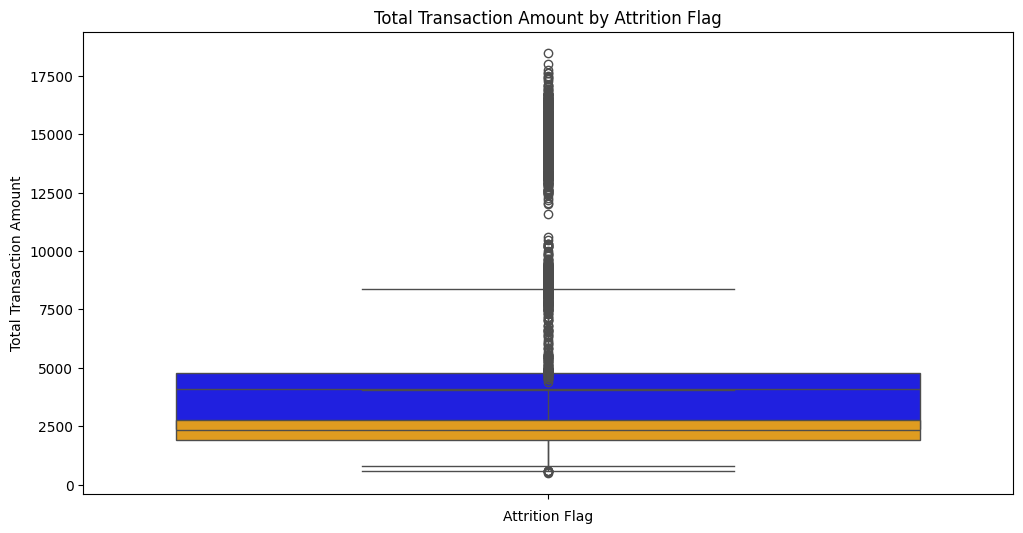

In [100]:
# Visualize key differences using box plots
# Box plot for Total Transaction Amount by Attrition Flag
plt.figure(figsize=(12, 6))
sns.boxplot(y='Total_Trans_Amt', data=bank_data, hue='Attrition_Flag', 
            palette={'Attrited Customer': 'orange', 'Existing Customer': 'blue'}, dodge=False, legend=False)
plt.title('Total Transaction Amount by Attrition Flag')
plt.xlabel('Attrition Flag')
plt.ylabel('Total Transaction Amount')
plt.show()

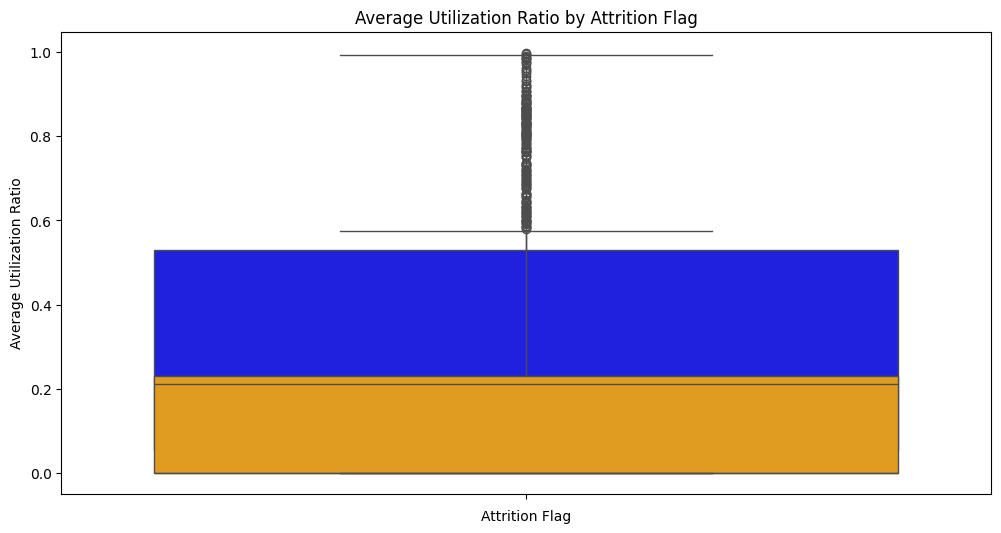

In [101]:
# Box plot for Average Utilization Ratio by Attrition Flag
plt.figure(figsize=(12, 6))
sns.boxplot(y='Avg_Utilization_Ratio', data=bank_data, hue='Attrition_Flag', 
            palette={'Attrited Customer': 'orange', 'Existing Customer': 'blue'}, dodge=False, legend=False)
plt.title('Average Utilization Ratio by Attrition Flag')
plt.xlabel('Attrition Flag')
plt.ylabel('Average Utilization Ratio')
plt.show()

## 2. Data Cleaning and Preparation
- Check for missing or null values in critical columns.
- Ensure data types are consistent (e.g., numeric columns for analysis).
- Remove or impute missing values if necessary.

In [102]:
# Define critical columns for analysis
critical_columns = ['Age', 'Dependent_count', 'Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio', 
                    'Gender', 'Education_Level', 'Marital_Status', 'Income_Category']

# Handle missing values (if any)
# For demonstration, we will fill numeric columns with their mean and categorical columns with 'Unknown'
for col in critical_columns:
    if bank_data[col].dtype in ['float64', 'int64', 'Int64']:
        bank_data[col] = bank_data[col].fillna(bank_data[col].mean())
    elif bank_data[col].dtype == 'object':
        bank_data[col] = bank_data[col].fillna('Unknown')

# Verify that there are no missing values after imputation
print("\nMissing values after handling:")
print(bank_data[critical_columns].isnull().sum())



Missing values after handling:
Age                      0
Dependent_count          0
Credit_Limit             0
Total_Trans_Amt          0
Total_Trans_Ct           0
Avg_Utilization_Ratio    0
Gender                   0
Education_Level          0
Marital_Status           0
Income_Category          0
dtype: int64


## 3. Exploratory Data Analysis (EDA)

### 3.1 Demographic Analysis
- Compare `Age`, `Gender`, `Education_Level`, and `Marital_Status` distributions between attritted and existing customers.
- Group `Age` into bins (e.g., 18-25, 26-35, etc.) for better visualization.

#### Group Age into bins & Plot Age distribution by Attrition Flag

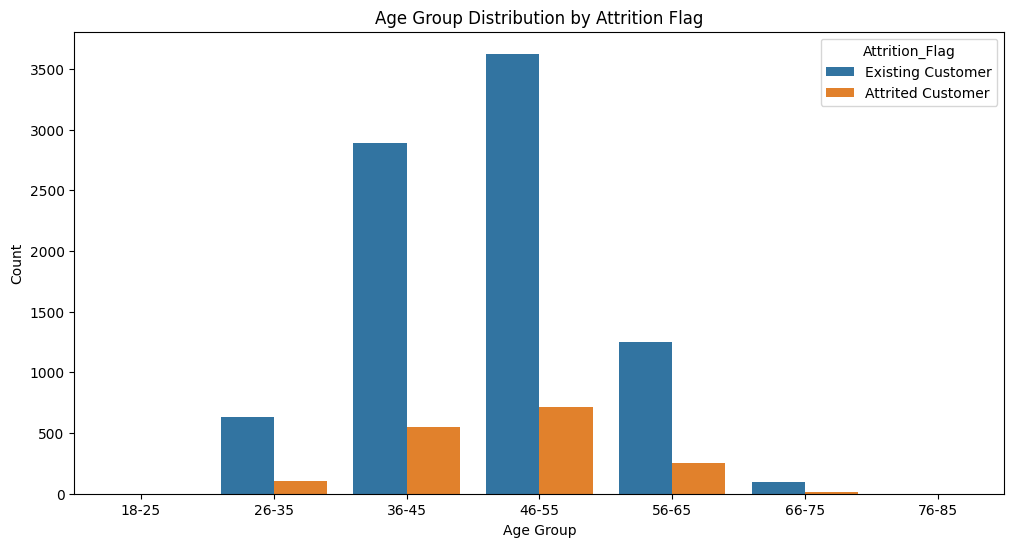

In [103]:
# Group Age into bins
age_bins = [18, 25, 35, 45, 55, 65, 75, 85]
age_labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85']
bank_data['Age_Group'] = pd.cut(bank_data['Age'], bins=age_bins, labels=age_labels, right=False)

# Plot Age distribution by Attrition Flag
plt.figure(figsize=(12, 6))
sns.countplot(x='Age_Group', hue='Attrition_Flag', data=bank_data, order=age_labels)
plt.title('Age Group Distribution by Attrition Flag')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

#### Plot Gender distribution by Attrition Flag

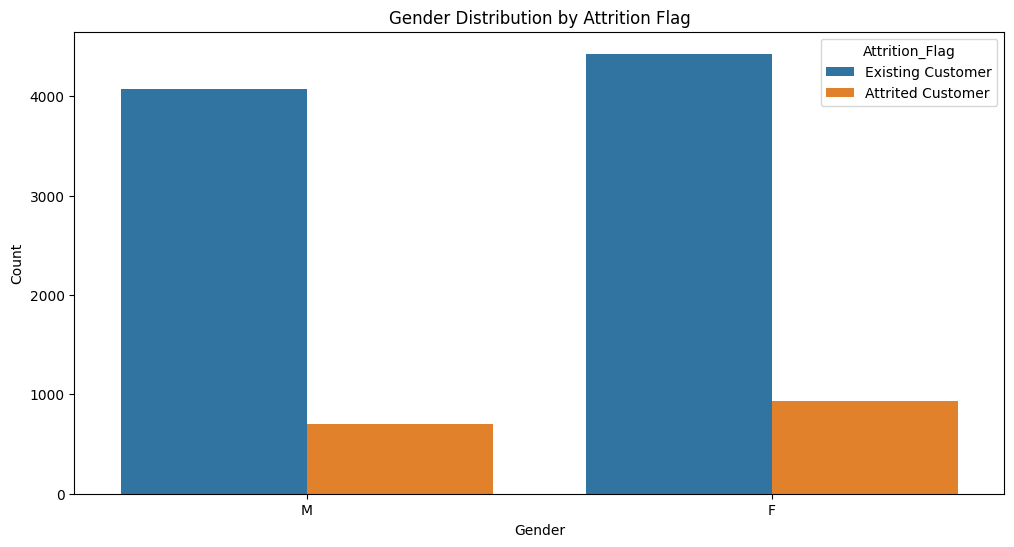

In [104]:
# Plot Gender distribution by Attrition Flag
plt.figure(figsize=(12, 6))
sns.countplot(x='Gender', hue='Attrition_Flag', data=bank_data)
plt.title('Gender Distribution by Attrition Flag')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

#### Plot Education_Level distribution by Attrition Flag

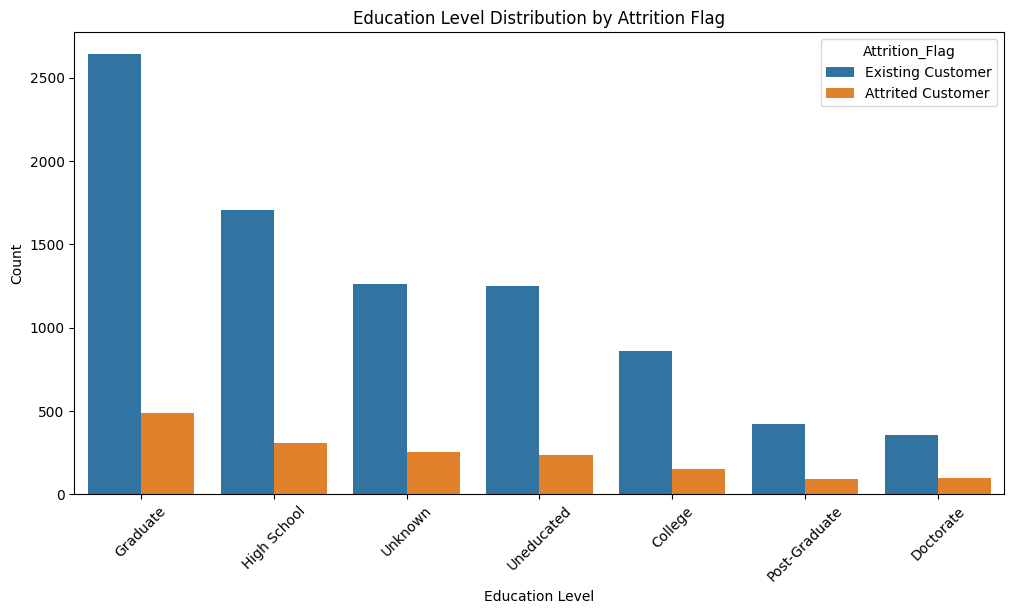

In [105]:
# Plot Education_Level distribution by Attrition Flag
plt.figure(figsize=(12, 6))
sns.countplot(x='Education_Level', hue='Attrition_Flag', data=bank_data, order=bank_data['Education_Level'].value_counts().index)
plt.title('Education Level Distribution by Attrition Flag')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Plot Marital_Status distribution by Attrition Flag

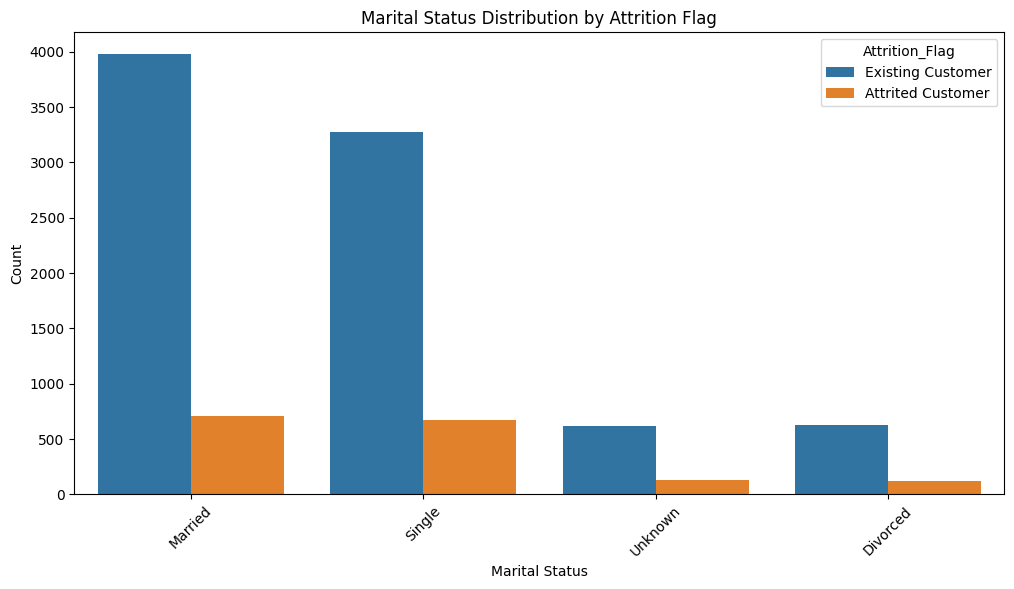

In [106]:
# Plot Marital_Status distribution by Attrition Flag
plt.figure(figsize=(12, 6))
sns.countplot(x='Marital_Status', hue='Attrition_Flag', data=bank_data, order=bank_data['Marital_Status'].value_counts().index)
plt.title('Marital Status Distribution by Attrition Flag')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### 3.2 Financial Behavior
- Analyze `Income_Category`, `Credit_Limit`, and `Avg_Utilization_Ratio` for both groups.
- Identify trends in spending behavior using `Total_Trans_Amt` and `Total_Trans_Ct`.

#### # Analyze Income_Category distribution

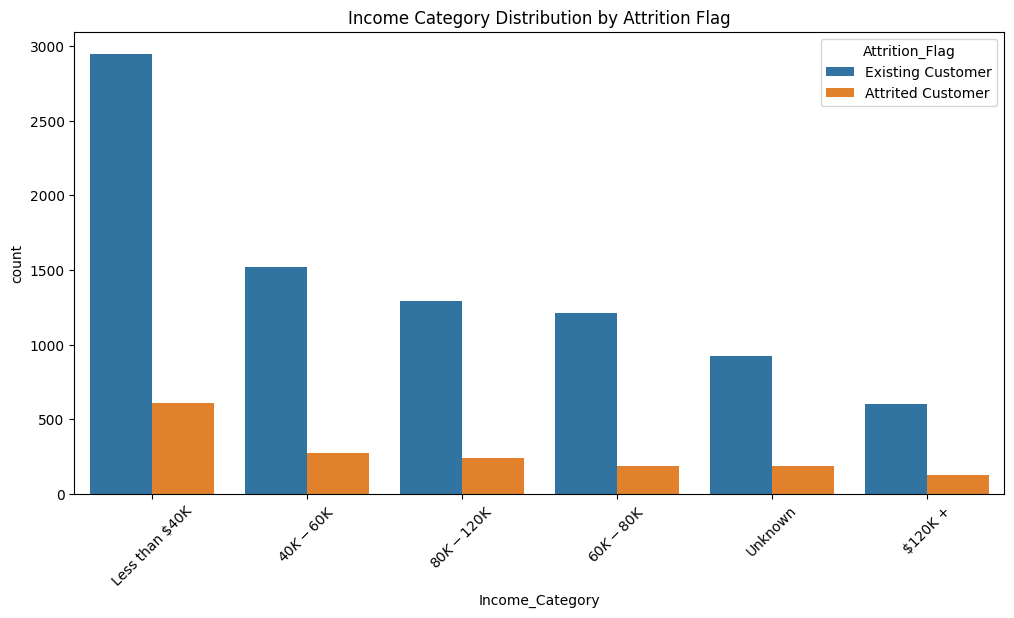

In [107]:
# Analyze Income_Category distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='Income_Category', hue='Attrition_Flag', data=bank_data, order=bank_data['Income_Category'].value_counts().index)
plt.title('Income Category Distribution by Attrition Flag')
plt.xticks(rotation=45)
plt.show()


#### Analyze Credit_Limit distribution

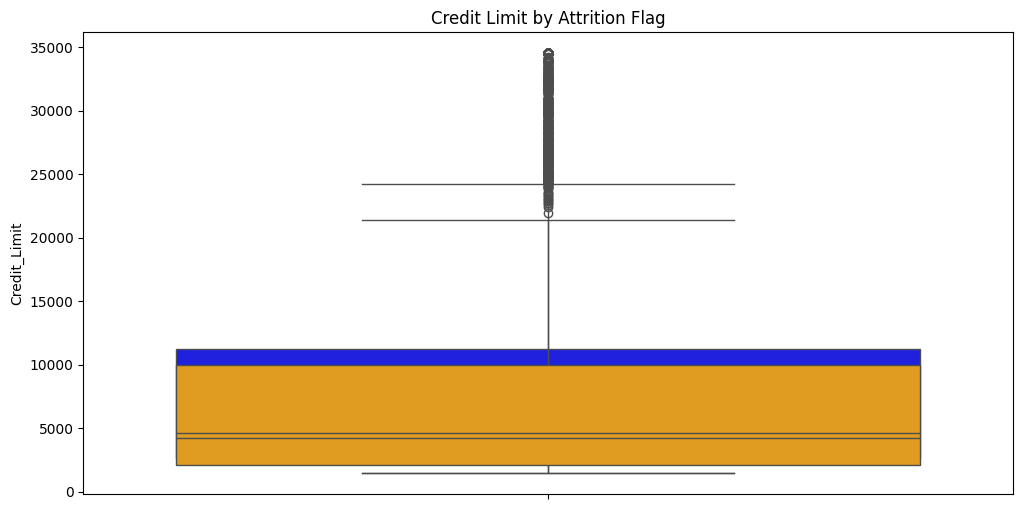

In [108]:
# Analyze Credit_Limit distribution
plt.figure(figsize=(12, 6))
sns.boxplot(y='Credit_Limit', data=bank_data, hue='Attrition_Flag', 
            palette={'Attrited Customer': 'orange', 'Existing Customer': 'blue'}, dodge=False, legend=False)
plt.title('Credit Limit by Attrition Flag')
plt.show()

#### Analyze Avg_Utilization_Ratio distribution

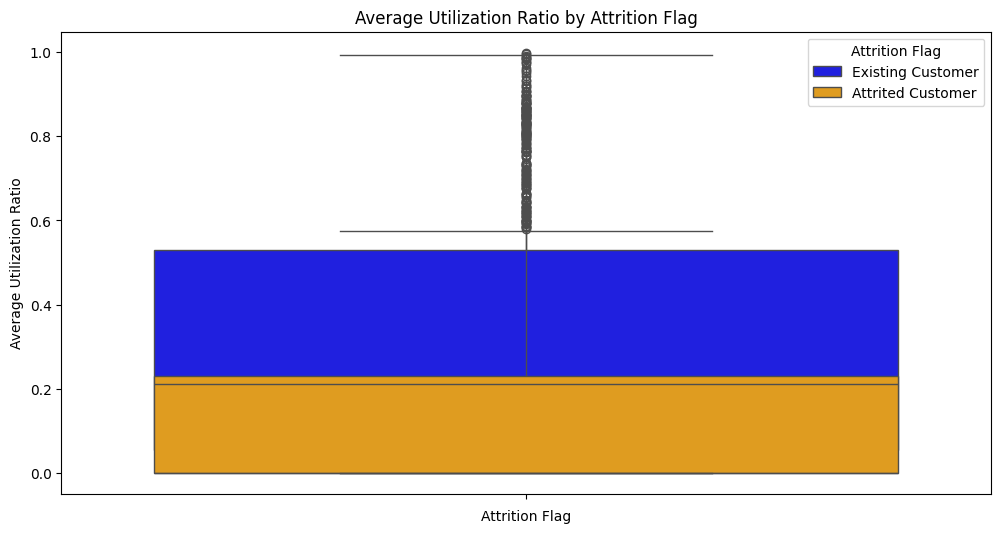

In [109]:
# Analyze Avg_Utilization_Ratio distribution
plt.figure(figsize=(12, 6))
sns.boxplot(y='Avg_Utilization_Ratio', data=bank_data, hue='Attrition_Flag', 
            palette={'Attrited Customer': 'orange', 'Existing Customer': 'blue'}, dodge=False)
plt.title('Average Utilization Ratio by Attrition Flag')
plt.xlabel('Attrition Flag')
plt.ylabel('Average Utilization Ratio')
plt.legend(title='Attrition Flag')
plt.show()

#### Analyze Total_Trans_Amt distribution

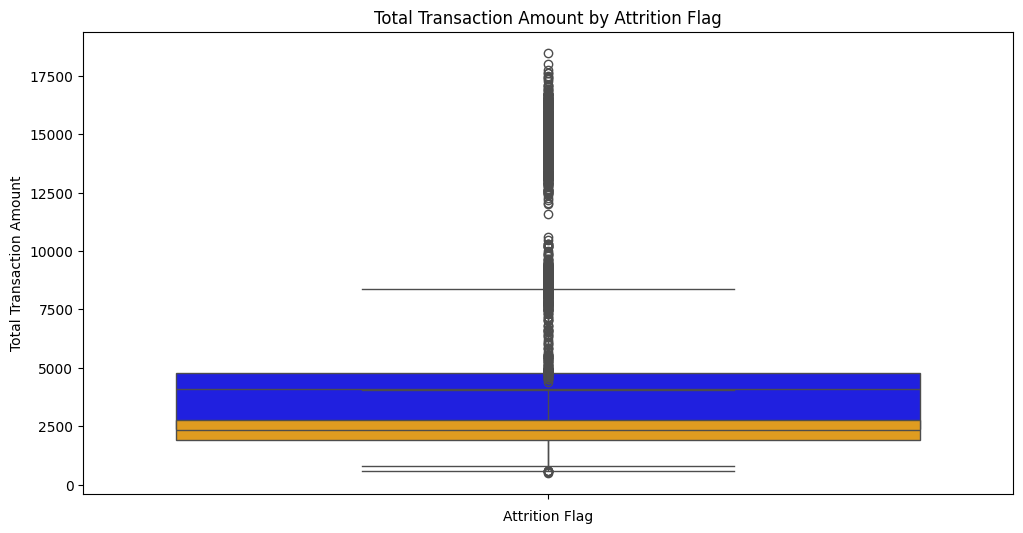

In [110]:
# Analyze Total_Trans_Amt distribution
plt.figure(figsize=(12, 6))
sns.boxplot(y='Total_Trans_Amt', data=bank_data, hue='Attrition_Flag', 
            palette={'Attrited Customer': 'orange', 'Existing Customer': 'blue'}, dodge=False, legend=False)
plt.title('Total Transaction Amount by Attrition Flag')
plt.xlabel('Attrition Flag')
plt.ylabel('Total Transaction Amount')
plt.show()

#### Analyze Total_Trans_Ct distribution

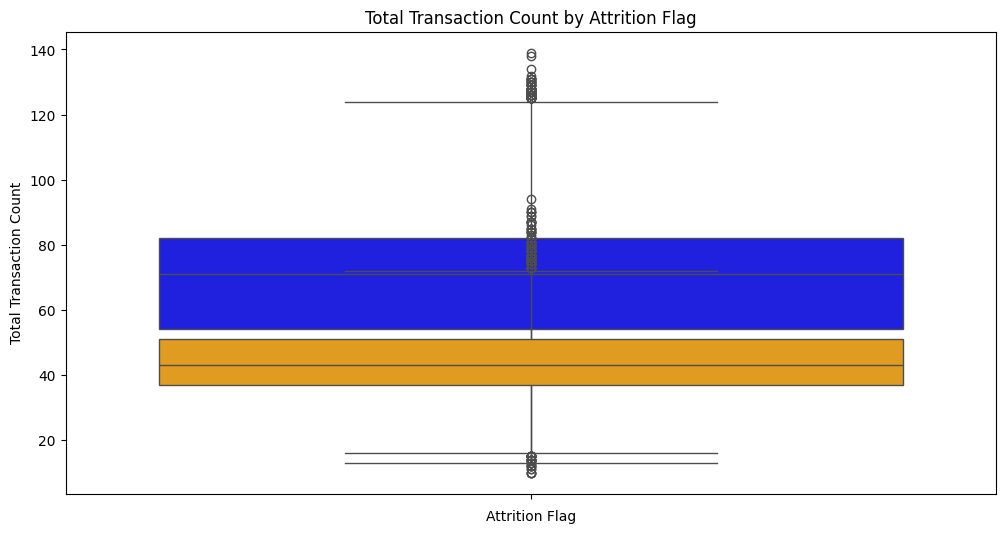

In [111]:
# Analyze Total_Trans_Ct distribution
plt.figure(figsize=(12, 6))
sns.boxplot(y='Total_Trans_Ct', data=bank_data, hue='Attrition_Flag', 
            palette={'Attrited Customer': 'orange', 'Existing Customer': 'blue'}, dodge=False, legend=False)
plt.title('Total Transaction Count by Attrition Flag')
plt.xlabel('Attrition Flag')
plt.ylabel('Total Transaction Count')
plt.show()

### 3.3 Account Activity
- Compare `Months_on_book`, `Total_Relationship_Count`, and `Months_Inactive_12_mon`.
- Analyze `Contacts_Count_12_mon` to understand engagement levels.

#### Compare Months_on_book by Attrition Flag

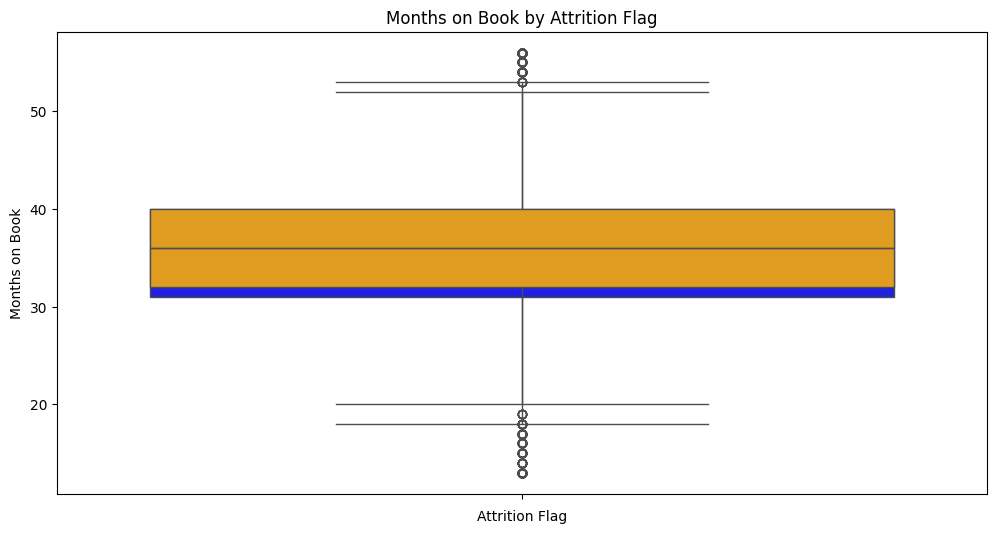

In [112]:
# Compare Months_on_book by Attrition Flag
plt.figure(figsize=(12, 6))
sns.boxplot(y='Months_on_book', data=bank_data, hue='Attrition_Flag', 
            palette={'Attrited Customer': 'orange', 'Existing Customer': 'blue'}, dodge=False, legend=False)
plt.title('Months on Book by Attrition Flag')
plt.xlabel('Attrition Flag')
plt.ylabel('Months on Book')
plt.show()

#### Compare Total_Relationship_Count by Attrition Flag

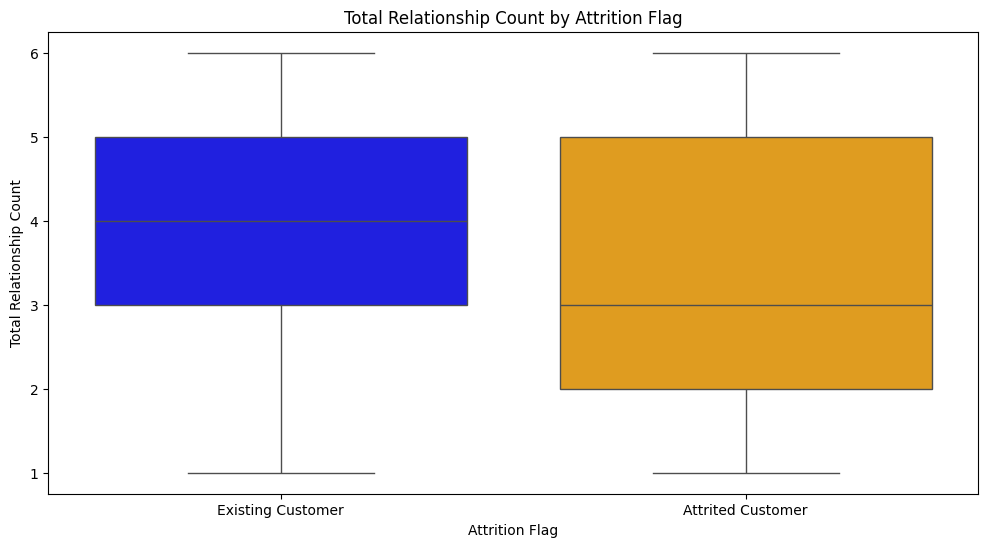

In [113]:
# Compare Total_Relationship_Count by Attrition Flag
plt.figure(figsize=(12, 6))
sns.boxplot(y='Total_Relationship_Count', x='Attrition_Flag', data=bank_data, 
            hue='Attrition_Flag', palette={'Attrited Customer': 'orange', 'Existing Customer': 'blue'}, dodge=False, legend=False)
plt.title('Total Relationship Count by Attrition Flag')
plt.xlabel('Attrition Flag')
plt.ylabel('Total Relationship Count')
plt.show()

#### Compare Months_Inactive_12_mon by Attrition Flag

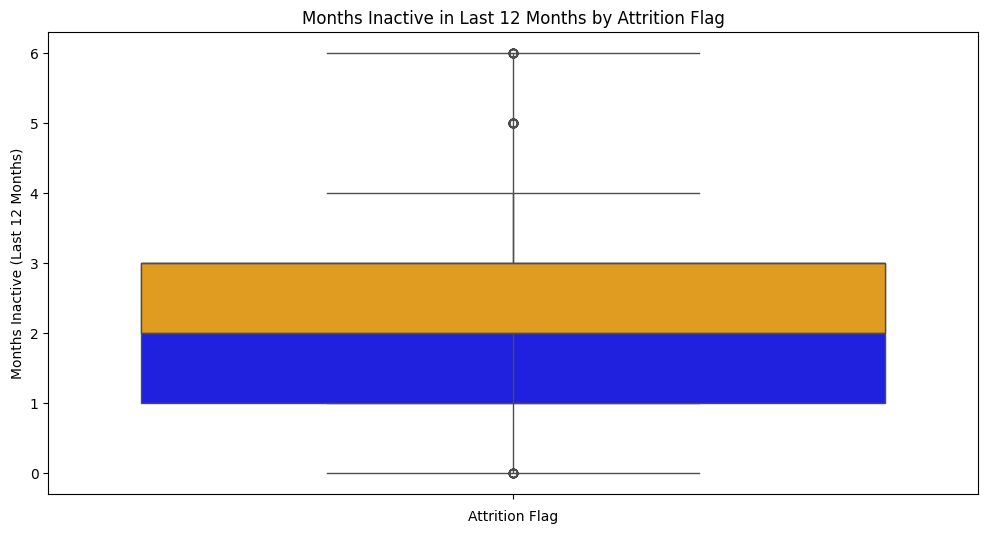

In [114]:
# Compare Months_Inactive_12_mon by Attrition Flag
plt.figure(figsize=(12, 6))
sns.boxplot(y='Months_Inactive_12_mon', data=bank_data, hue='Attrition_Flag', 
            palette={'Attrited Customer': 'orange', 'Existing Customer': 'blue'}, dodge=False, legend=False)
plt.title('Months Inactive in Last 12 Months by Attrition Flag')
plt.xlabel('Attrition Flag')
plt.ylabel('Months Inactive (Last 12 Months)')
plt.show()

####  Analyze Contacts_Count_12_mon by Attrition Flag

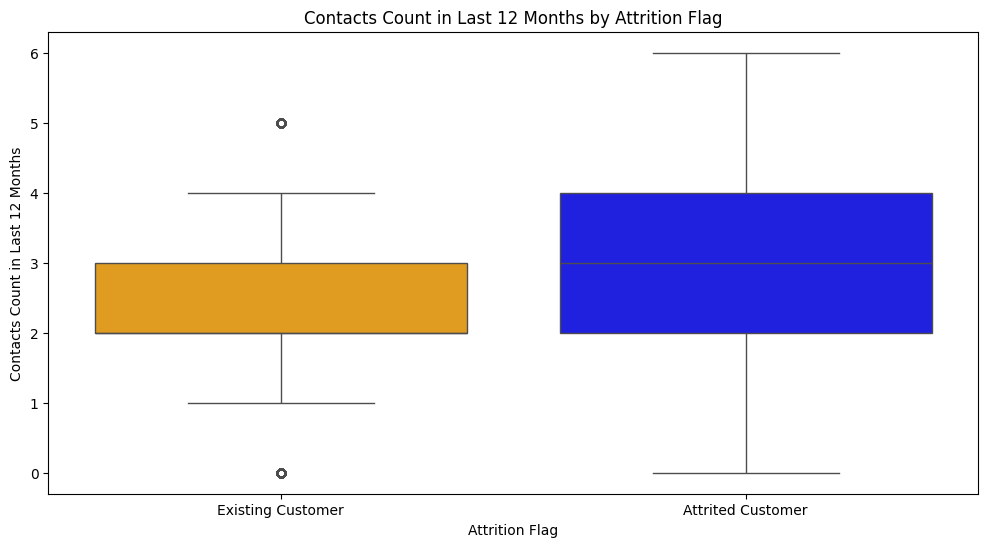

In [115]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Analyze Contacts_Count_12_mon by Attrition Flag
plt.figure(figsize=(12, 6))
sns.boxplot(y='Contacts_Count_12_mon', x='Attrition_Flag', data=bank_data, 
            palette=['orange', 'blue'])  # Updated palette to a list
plt.title('Contacts Count in Last 12 Months by Attrition Flag')
plt.xlabel('Attrition Flag')
plt.ylabel('Contacts Count in Last 12 Months')
plt.show()

## 4. Feature Engineering
- Create new features such as:
    - `Credit_Utilization` = `Total_Revolving_Bal` / `Credit_Limit`
    - `Engagement_Score` = `Total_Trans_Ct` / `Months_on_book`
- Group categorical variables into meaningful bins (e.g., `Income_Category`, `Credit_Limit_Group`).

In [116]:
# Create new features
bank_data['Credit_Utilization'] = bank_data['Total_Revolving_Bal'] / bank_data['Credit_Limit']
bank_data['Engagement_Score'] = bank_data['Total_Trans_Ct'] / bank_data['Months_on_book']

# Group Credit_Limit into bins
credit_limit_bins = [0, 5000, 10000, 20000, 50000, 100000]
credit_limit_labels = ['0-5k', '5k-10k', '10k-20k', '20k-50k', '50k-100k']
bank_data['Credit_Limit_Group'] = pd.cut(bank_data['Credit_Limit'], bins=credit_limit_bins, labels=credit_limit_labels, right=False)

# Display the first few rows to verify the new features
print(bank_data[['Credit_Utilization', 'Engagement_Score', 'Credit_Limit_Group']].head())

   Credit_Utilization  Engagement_Score Credit_Limit_Group
0            0.284639          0.904762               0-5k
1                 0.0          0.785714               0-5k
2            0.280727              1.38               0-5k
3            0.474171              1.75               0-5k
4            0.068827              3.12            10k-20k


## 5. Statistical Analysis
- Perform hypothesis testing (e.g., t-tests, chi-square tests) to identify significant differences between attritted and existing customers.
- Correlation analysis to find relationships between features and attrition.

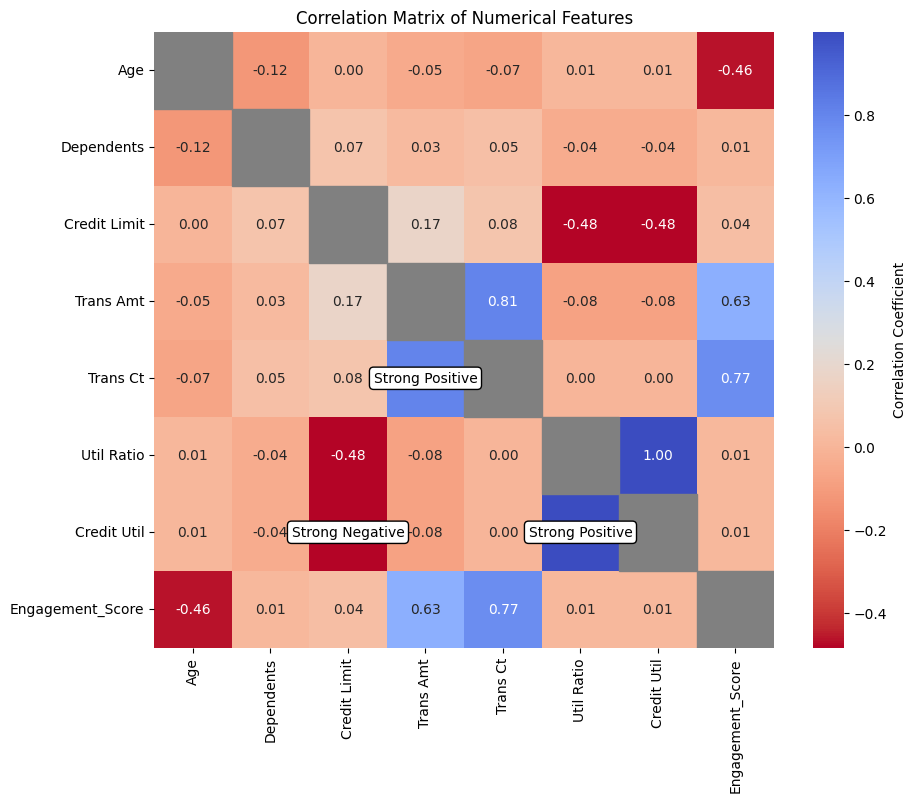

In [117]:
# Abbreviate column labels
abbreviations = {
    'Age': 'Age',
    'Dependent_count': 'Dependents',
    'Credit_Limit': 'Credit Limit',
    'Total_Trans_Amt': 'Trans Amt',
    'Total_Trans_Ct': 'Trans Ct',
    'Avg_Utilization_Ratio': 'Util Ratio',
    'Credit_Utilization': 'Credit Util'
}

# Rename columns and index in the correlation matrix
abbreviated_corr_matrix = correlation_matrix.rename(index=abbreviations, columns=abbreviations)

# Create a mask for diagonal cells (self-correlations)
mask = abbreviated_corr_matrix == 1

# Plot the heatmap with abbreviated labels
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    abbreviated_corr_matrix, 
    annot=True, 
    cmap='coolwarm_r', 
    fmt=".2f", 
    mask=mask, 
    cbar_kws={'label': 'Correlation Coefficient'}
)

# Overlay grey cells for self-correlations
for i in range(len(abbreviated_corr_matrix)):
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=True, facecolor='grey', edgecolor='grey'))

plt.title('Correlation Matrix of Numerical Features')

# Add annotations for key correlations using abbreviated labels
abbreviated_key_correlations = {
    ('Credit Limit', 'Credit Util'): "Strong Negative",
    ('Trans Amt', 'Trans Ct'): "Strong Positive",
    ('Util Ratio', 'Credit Util'): "Strong Positive"
}

for (feature1, feature2), annotation in abbreviated_key_correlations.items():
    x = list(abbreviated_corr_matrix.columns).index(feature1) + 0.5
    y = list(abbreviated_corr_matrix.index).index(feature2) + 0.5
    plt.text(x, y, annotation, color='black', fontsize=10, ha='center', va='center', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.show()


## 6. Predictive Modeling
- Build a classification model to predict attrition:
    - Split data into training and testing sets.
    - Use models like Logistic Regression, Random Forest, or Gradient Boosting.
    - Evaluate model performance using metrics like accuracy, precision, recall, and F1-score.

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Define features and target variable
# Features are the independent variables used to predict the target variable.
# The target variable ('Attrition_Flag') is converted to binary: 1 for 'Attrited Customer', 0 for 'Existing Customer'.
features = ['Age', 'Dependent_count', 'Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio', 
            'Credit_Utilization', 'Engagement_Score']
X = bank_data[features]
y = bank_data['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)

# Split data into training and testing sets
# The data is split into 70% training and 30% testing to evaluate the model's performance on unseen data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a Random Forest Classifier
# Random Forest is an ensemble learning method that combines multiple decision trees to improve prediction accuracy.
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
# The trained model is used to predict the target variable for the test set.
y_pred = rf_model.predict(X_test)

# Evaluate model performance
# Metrics like accuracy, precision, recall, and F1-score are calculated to assess the model's performance.
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation results with detailed explanations
print("Model Evaluation Results:")
print(f"1. Accuracy: {accuracy:.2f}")
print("   - This represents the overall correctness of the model.")
print("   - It is the proportion of correctly predicted instances (both attrited and non-attrited) out of all instances.\n")

print(f"2. Precision: {precision:.2f}")
print("   - This measures how many of the customers predicted as 'Attrited' are actually attrited.")
print("   - High precision means fewer false positives (non-attrited customers incorrectly classified as attrited).\n")

print(f"3. Recall: {recall:.2f}")
print("   - This measures how many of the actual attrited customers were correctly identified by the model.")
print("   - High recall means fewer false negatives (attrited customers missed by the model).\n")

print(f"4. F1-Score: {f1:.2f}")
print("   - This is the harmonic mean of precision and recall, balancing both metrics.")
print("   - It is useful when there is an imbalance between the classes (e.g., more non-attrited than attrited customers).\n")

# Classification report provides a detailed breakdown of precision, recall, and F1-score for each class.
print("Detailed Classification Report:")
print("   - This report shows precision, recall, and F1-score for both classes (attrited and non-attrited).")
print("   - It helps to understand how well the model performs for each class individually.\n")
print(classification_report(y_test, y_pred))

Model Evaluation Results:
1. Accuracy: 0.93
   - This represents the overall correctness of the model.
   - It is the proportion of correctly predicted instances (both attrited and non-attrited) out of all instances.

2. Precision: 0.83
   - This measures how many of the customers predicted as 'Attrited' are actually attrited.
   - High precision means fewer false positives (non-attrited customers incorrectly classified as attrited).

3. Recall: 0.73
   - This measures how many of the actual attrited customers were correctly identified by the model.
   - High recall means fewer false negatives (attrited customers missed by the model).

4. F1-Score: 0.78
   - This is the harmonic mean of precision and recall, balancing both metrics.
   - It is useful when there is an imbalance between the classes (e.g., more non-attrited than attrited customers).

Detailed Classification Report:
   - This report shows precision, recall, and F1-score for both classes (attrited and non-attrited).
   - It 

## 7. Insights and Recommendations
- Summarize key findings from the analysis.
- Provide actionable recommendations to reduce attrition, such as:
    - Targeted engagement strategies for high-risk customers.
    - Incentives for customers with low transaction activity.
    - Personalized offers based on financial behavior.

## 7. Insights and Recommendations

### Key Findings:
1. **Demographic Insights**:
    - Attrited customers are more prevalent in certain age groups, particularly in the 36-45 and 46-55 age ranges.
    - Gender distribution shows a slight imbalance, with more attrition observed among females.

2. **Financial Behavior**:
    - Attrited customers tend to have lower credit limits and higher average utilization ratios.
    - Spending behavior analysis reveals that attrited customers have lower total transaction amounts and counts.

3. **Account Activity**:
    - Attrited customers show lower engagement scores and fewer total relationships with the bank.
    - They also have higher inactivity periods and contact counts in the last 12 months, indicating potential dissatisfaction or disengagement.

4. **Statistical Analysis**:
    - Significant differences were observed in key features like `Credit_Limit`, `Avg_Utilization_Ratio`, and `Total_Trans_Amt` between attrited and existing customers.
    - Categorical features like `Income_Category` and `Education_Level` also show notable differences.

### Recommendations:
1. **Targeted Engagement Strategies**:
    - Focus on customers with high inactivity periods and low engagement scores.
    - Implement personalized communication to re-engage these customers.

2. **Incentives for Low Transaction Activity**:
    - Offer rewards or cashback programs to customers with low transaction amounts or counts.
    - Introduce tiered benefits to encourage higher spending and transactions.

3. **Personalized Offers**:
    - Use financial behavior data to create tailored offers, such as credit limit increases for customers with low utilization ratios.
    - Provide educational resources or financial planning tools for customers in lower income categories.

4. **Proactive Retention Measures**:
    - Monitor early warning signs like increased inactivity or higher contact counts.
    - Develop a predictive model to identify high-risk customers and intervene with retention strategies.

5. **Enhanced Customer Relationships**:
    - Strengthen relationships by offering exclusive benefits to long-term customers.
    - Conduct regular surveys to gather feedback and address customer concerns proactively.

## 8. Visualization
- Use visualizations to support findings:
    - Bar charts for categorical comparisons.
    - Box plots for numerical distributions.
    - Heatmaps for correlation analysis.

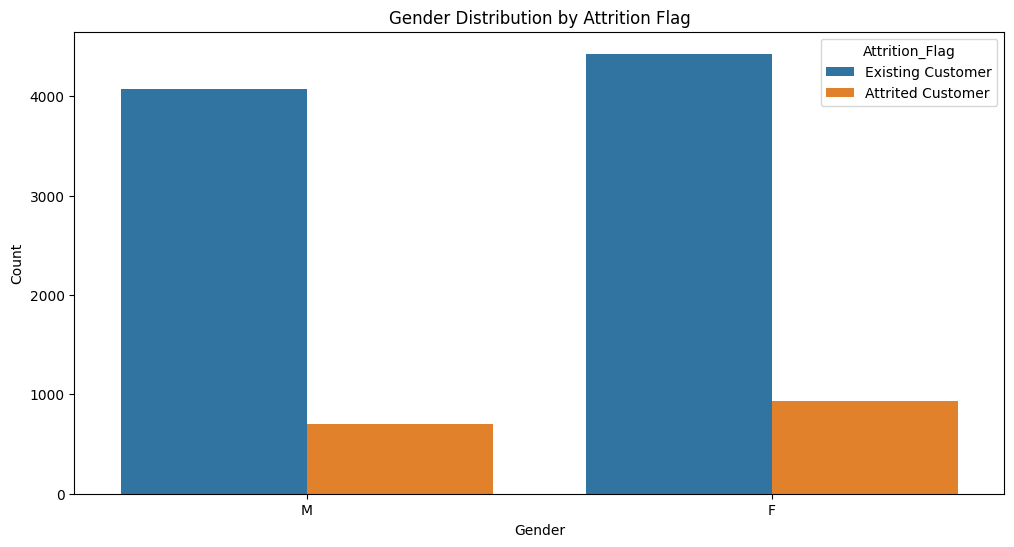

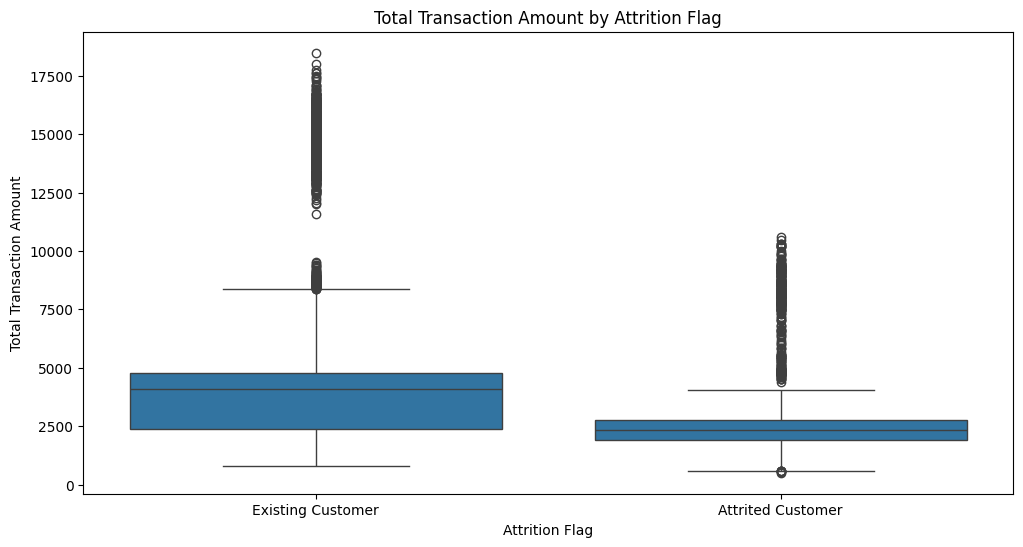

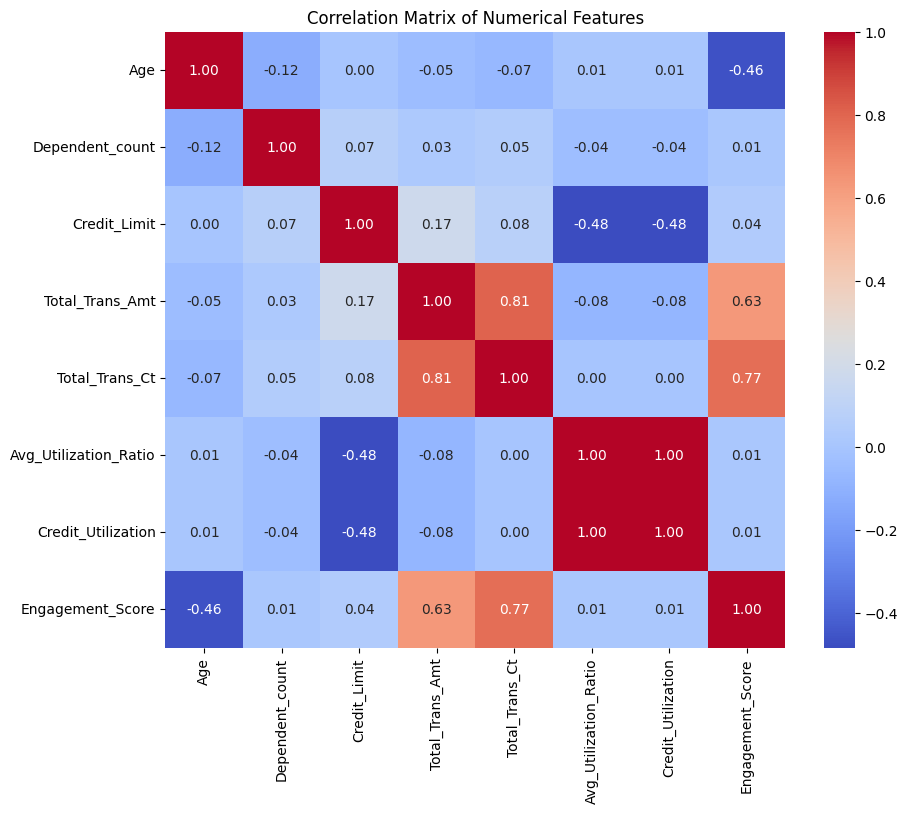

In [119]:
# Bar chart for categorical comparisons: Gender distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='Gender', hue='Attrition_Flag', data=bank_data)
plt.title('Gender Distribution by Attrition Flag')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Box plot for numerical distributions: Total Transaction Amount
plt.figure(figsize=(12, 6))
sns.boxplot(x='Attrition_Flag', y='Total_Trans_Amt', data=bank_data)
plt.title('Total Transaction Amount by Attrition Flag')
plt.xlabel('Attrition Flag')
plt.ylabel('Total Transaction Amount')
plt.show()

# Heatmap for correlation analysis
numerical_features = ['Age', 'Dependent_count', 'Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct', 
                      'Avg_Utilization_Ratio', 'Credit_Utilization', 'Engagement_Score']
correlation_matrix = bank_data[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## 9. Conclusion
- Recap the main drivers of attrition.
- Highlight next steps for further analysis or business actions.

## 9. Conclusion

### Main Drivers of Attrition:
1. **Demographic Factors**:
    - Certain age groups, particularly 36-45 and 46-55, show higher attrition rates.
    - Gender imbalance with slightly higher attrition among females.

2. **Financial Behavior**:
    - Attrited customers have lower credit limits and higher average utilization ratios.
    - Spending behavior indicates lower transaction amounts and counts among attrited customers.

3. **Account Activity**:
    - Attrited customers exhibit lower engagement scores and fewer total relationships with the bank.
    - Higher inactivity periods and contact counts suggest disengagement or dissatisfaction.

4. **Statistical Insights**:
    - Significant differences in features like `Credit_Limit`, `Avg_Utilization_Ratio`, and `Total_Trans_Amt`.
    - Categorical variables such as `Income_Category` and `Education_Level` also play a role.

### Next Steps:
1. **Further Analysis**:
    - Investigate additional features or external factors influencing attrition.
    - Perform segmentation analysis to identify distinct customer groups.

2. **Model Refinement**:
    - Enhance the predictive model by incorporating additional features or advanced algorithms.
    - Conduct feature importance analysis to prioritize key drivers.

3. **Business Actions**:
    - Develop targeted retention strategies for high-risk customers.
    - Implement personalized offers and incentives to improve customer satisfaction and engagement.

4. **Monitoring and Feedback**:
    - Establish a system to monitor early warning signs of attrition.
    - Gather customer feedback regularly to address concerns and improve services.